In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [2]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

/home/phil/unimib/tesi/src


In [3]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

Numbero di immagini CT in data/train/ : 213
Numbero di immagini MRI in data/train/ : 255
Numbero di immagini PET in data/train/ : 170
Numbero di immagini CT in data/val/ : 85
Numbero di immagini MRI in data/val/ : 102
Numbero di immagini PET in data/val/ : 68
Numbero di immagini CT in data/test/ : 57
Numbero di immagini MRI in data/test/ : 69
Numbero di immagini PET in data/test/ : 46


In [4]:
#creo la lista di file bilanciata: n.b  la percentuale viene mantenuta
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

for l in _final_file_names:
    random.shuffle(l)

In [5]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 510 , Validation: 204 , Test: 138


## Converto le immagini in tensori

In [6]:
from skimage import io
import matplotlib.pyplot as plt
import cv2
import numpy as np

### X, Y, L

In [7]:
hight=128
width=192

(182, 218, 3)


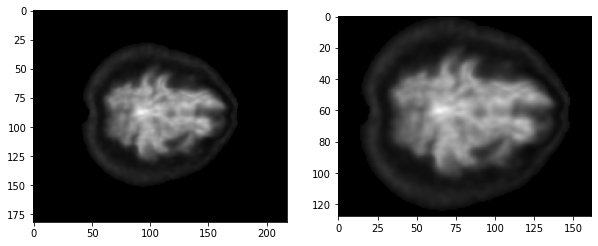

In [8]:
img = cv2.imread(directories[0]+train_final_file_names[random.randint(0,100)])
print(img.shape)
h, w, c = img.shape

img_cropped = img[int(h/2)-int(hight/2):int(h/2)+int(hight/2),int(w/2)-int(width/2)+15:int(w/2)+int(width/2)-15]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_cropped)

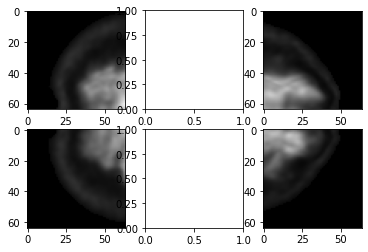

In [9]:
crop_img1 = img_cropped[:64, :int(width/3)]
#crop_img2 = img_cropped[:64, int(width/3):int(width/3)*2]
crop_img3 = img_cropped[:64, -64:]

crop_img4 = img_cropped[64:, :int(width/3)]
#crop_img5 = img_cropped[64:, int(width/3):int(width/3)*2]
crop_img6 = img_cropped[64:, -64:]

ax = plt.subplot(2,3,1)
plt.imshow(crop_img1)
ax = plt.subplot(2,3,2)
#plt.imshow(crop_img2)
ax = plt.subplot(2,3,3)
plt.imshow(crop_img3)

ax = plt.subplot(2,3,4)
plt.imshow(crop_img4)
ax = plt.subplot(2,3,5)
#plt.imshow(crop_img5)
ax = plt.subplot(2,3,6)
plt.imshow(crop_img6)

In [10]:
def crop(img):
    hight=128
    width=192
    b=15
    h, w = img.shape
    return img[int(h/2)-int(hight/2):int(h/2)+int(hight/2),int(w/2)-int(width/2)+b:int(w/2)+int(width/2)-b]

In [11]:
def split_in_six(img):
    width = 192
    crop_img1 = img[:64, :int(width/3)]
    #crop_img2 = img[:64, int(width/3):int(width/3)*2]
    crop_img3 = img[:64, -64:]
    crop_img4 = img[64:, :int(width/3)]
    #crop_img5 = img[64:, int(width/3):int(width/3)*2]
    crop_img6 = img[64:, -64:]
    return crop_img1, crop_img3, crop_img4, crop_img6

In [12]:
def read_4(path):
    #prototipo x    
    img = io.imread(path[0])
    img = crop(img)
    img_1, img_3, img_4, img_6 = split_in_six(img)
    img_1 = cv2.flip(img_1, 0)
    img_4 = cv2.flip(img_4, -1)
    img_6 = cv2.flip(img_6, 1)
    x = np.dstack((img_1,img_3,img_4,img_6))
    #prototipo y
    if 'CT' in path[0]:
        label=[0,0,0,0]
    if 'MRI' in path[0]:
        label=[1,1,1,1]
    if 'PET' in path[0]:
        label=[2,2,2,2]
    #lista nomi immagini croppate
    a, b = path[0].split('.')
    l = [a+'_1.png',a+'_3.png',a+'_4.png',a+'_6.png']
    
    for img in path[1:]:
        #y
        if 'CT' in img:
            label.extend([0]*4)
        if 'MRI' in img:
            label.extend([1]*4)
        if 'PET' in img:
            label.extend([2]*4)
        a, b = img.split('.')
        l.append([a+'_1.png',a+'_3.png',a+'_4.png',a+'_6.png'])
        #x
        img = io.imread(img)
        img = crop(img)
        img_1, img_3, img_4, img_6 = split_in_six(img)
        img_1 = cv2.flip(img_1, 1)
        img_4 = cv2.flip(img_4, -1)
        img_6 = cv2.flip(img_6, 0)
        img = np.dstack((img_1,img_3,img_4,img_6))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    label = np.concatenate((label,))
    return x, label, l

In [13]:
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)
        
x_train, y_train, train_cropped_images = read_4(train_paths)
x_val, y_val, val_cropped_images = read_4(val_paths)
x_test, y_test, test_cropped_images = read_4(test_paths)

In [14]:
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error!')
    else: 
        print('Ok!')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok!
Ok!
Ok!
Clusters: 3


### Reshape images for autoencoder

In [15]:
def ReshapeCAE(array):
    array = array.reshape(array.shape + (1,))
    array = array/255.
    return array

In [16]:
x_train = ReshapeCAE(x_train)
x_val = ReshapeCAE(x_val)
x_test = ReshapeCAE(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2040, 64, 64, 1)
(816, 64, 64, 1)
(552, 64, 64, 1)


# Convolutional Autoencoder

In [17]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model

Using TensorFlow backend.


## CAE Conv2DTranspose (paper)

In [18]:
def CAE_Conv2DTranspose(input_shape=(64, 64, 1), filters=[8, 16, 32, 64, 128, 256, 512, 1024, 30]):
    
    '''
    CAE_Upsampling2D convolutional autoencoder model.
    
    Arguments:
        img_shape: (128, 128, 1)
        filters: [32, 64, 128, 256, 512, 1024, 3]
    
    return:
        Models of autoencoder and encoder
            (autoencoder, encoder)
            
        outputs:
            autoencoder: encoded
            encoder: decoded
    '''
    
    input_img = Input(shape=input_shape)
    
    #Encoder
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Conv2D(filters[1], 3, strides=2, padding='same', activation='relu', name='conv2')(x)
    x = Conv2D(filters[2], 3, strides=2, padding='same', activation='relu', name='conv3')(x)
    x = Conv2D(filters[3], 3, strides=2, padding='same', activation='relu', name='conv4')(x)
    x = Conv2D(filters[4], 3, strides=2, padding='same', activation='relu', name='conv5')(x)
    x = Conv2D(filters[5], 3, strides=2, padding='same', activation='relu', name='conv6')(x)
    
    x = Flatten()(x)
    
    encoded = Dense(units=filters[-1], name='embedding')(x)
    
    y = Dense(units=3, name='input_clustering')(encoded)
    
    #Decoder
    x = Dense(units=filters[5]*int(input_shape[0]/64)*int(input_shape[0]/64), activation='relu')(encoded)

    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape((int(input_shape[0]/64), int(input_shape[0]/64), filters[5]))(x)
    
    x = Conv2DTranspose(filters[4], 3, strides=2, padding='same', activation='relu', name='deconv6')(x)
    x = Conv2DTranspose(filters[3], 3, strides=2, padding='same', activation='relu', name='deconv5')(x)
    x = Conv2DTranspose(filters[2], 3, strides=2, padding='same', activation='relu', name='deconv4')(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding='same', activation='relu', name='deconv3')(x)
    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_img, outputs=decoded, name='CAE_Conv2DTranspose'), Model(inputs=input_img, outputs=[encoded, y], name='CE')

In [19]:
autoencoder, encoder = CAE_Conv2DTranspose()
encoder.summary()
autoencoder.summary()

Model: "CE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 8)         208       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 16)        1168      
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 32)          4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 64)          18496     
_________________________________________________________________
conv5 (Conv2D)               (None, 2, 2, 128)         73856     
_________________________________________________________________
conv6 (Conv2D)               (None, 1, 1, 256)         295168   

# Pretrain

In [20]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_epochs = 1000
batch_size = 64

In [21]:
save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [25]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, 
                x_train, 
                batch_size=batch_size, 
                epochs=pretrain_epochs,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
)

Train on 2040 samples, validate on 816 samples
Epoch 1/1000
2040/2040 [==============================] - 7s 3ms/step - loss: 0.1459 - val_loss: 0.0687
Epoch 2/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0516 - val_loss: 0.0349
Epoch 3/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0283 - val_loss: 0.0198
Epoch 4/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 5/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0137 - val_loss: 0.0119
Epoch 6/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 7/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 8/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 9/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 10/1000
204

2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 156/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 157/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 158/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 159/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 160/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 161/1000
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 162/1000
2040/2040 [==============================] - 7s 4ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 163/1000
2040/2040 [==============================] - 10s 5ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 164/1000
2040/2040 [==============================] - 

2040/2040 [==============================] - 7s 4ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 310/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 311/1000
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 312/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 313/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 314/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 315/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 316/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 317/1000
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 318/1000
2040/2040 [==============================] - 7

2040/2040 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 464/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 465/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 466/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 467/1000
2040/2040 [==============================] - 9s 5ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 468/1000
2040/2040 [==============================] - 11s 5ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 469/1000
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 470/1000
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 471/1000
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 472/1000
2040/2040 [==============================] - 

2040/2040 [==============================] - 5s 3ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 618/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 619/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 620/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 621/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 622/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 623/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 624/1000
2040/2040 [==============================] - 5s 3ms/step - loss: 9.9966e-04 - val_loss: 0.0015
Epoch 625/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.8874e-04 - val_loss: 0.0015
Epoch 626/1000
2040/2040 [===========================

2040/2040 [==============================] - 5s 2ms/step - loss: 9.8459e-04 - val_loss: 0.0015
Epoch 769/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 770/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 771/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 772/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 773/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.6851e-04 - val_loss: 0.0015
Epoch 774/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.4406e-04 - val_loss: 0.0015
Epoch 775/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.3113e-04 - val_loss: 0.0015
Epoch 776/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.2164e-04 - val_loss: 0.0014
Epoch 777/1000
2040/2040 [===============

Epoch 918/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 919/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 920/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 921/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.4283e-04 - val_loss: 0.0015
Epoch 922/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.1419e-04 - val_loss: 0.0015
Epoch 923/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.3064e-04 - val_loss: 0.0014
Epoch 924/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.8485e-04 - val_loss: 0.0015
Epoch 925/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.4553e-04 - val_loss: 0.0015
Epoch 926/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.1366e-04 - val_loss: 0.0014
Epoch 927/1000
2040/20

Epoch 993/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 8.8530e-04 - val_loss: 0.0014
Epoch 994/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.8591e-04 - val_loss: 0.0015
Epoch 995/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.3958e-04 - val_loss: 0.0015
Epoch 996/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.1773e-04 - val_loss: 0.0014
Epoch 997/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 8.9257e-04 - val_loss: 0.0014
Epoch 998/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.7530e-04 - val_loss: 0.0015
Epoch 999/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 9.9860e-04 - val_loss: 0.0015
Epoch 1000/1000
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0015 - val_loss: 0.0020


## Plot train and validation loss 

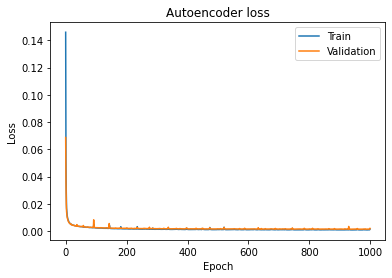

In [26]:
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [22]:
save_as = '/cae_conv2Dtranspose_weights_cropped4.h5'

In [28]:
autoencoder.save_weights(save_dir+save_as)

# Show prediction after pretraining CAE

In [23]:
autoencoder.load_weights(save_dir+save_as)

In [24]:
directories = ['data/train/', 'data/val/', 'data/test/']
s = ['CT', 'MRI', 'PET']

model = autoencoder

## Pred

In [25]:
def GetListPerType(directory,scan):
    names = [f for f in listdir(directory) if f[:2]==scan[:2]]
    return names

def GetImage(names,directory,n):
    image = io.imread(directory+names[n])
    return image

In [26]:
def pred_4(d,s):
    img = crop(GetImage(GetListPerType(d,s),d,n))
    img_1, img_3, img_4, img_6 = split_in_six(img)
    img_1 = cv2.flip(img_1, 1)
    img_4 = cv2.flip(img_4, -1)
    img_6 = cv2.flip(img_6, 0)
    
    plt.figure(figsize=(15,7))
    plt.gray()
    
    ax = plt.subplot(2,5,1)
    plt.imshow(img)
    ax = plt.subplot(2,5,2)
    plt.imshow(img_1)
    ax = plt.subplot(2,5,3)
    plt.imshow(img_3)
    ax = plt.subplot(2,5,4)
    plt.imshow(img_4)
    ax = plt.subplot(2,5,5)
    plt.imshow(img_6)

    img_1 = img_1.reshape((1,) + img_1.shape + (1,))
    img_3 = img_3.reshape((1,) + img_3.shape + (1,))
    img_4 = img_4.reshape((1,) + img_4.shape + (1,))
    img_6 = img_6.reshape((1,) + img_6.shape + (1,))

    img_1_p = model.predict(img_1)
    img_1_p = img_1_p.reshape((64,64))
    img_3_p = model.predict(img_3)
    img_3_p = img_3_p.reshape((64,64))
    img_4_p = model.predict(img_4)
    img_4_p = img_4_p.reshape((64,64))
    img_6_p = model.predict(img_6)
    img_6_p = img_6_p.reshape((64,64))
    
    ax = plt.subplot(2,5,7)
    plt.imshow(img_1_p)
    ax = plt.subplot(2,5,8)
    plt.imshow(img_3_p)
    ax = plt.subplot(2,5,9)
    plt.imshow(img_4_p)
    ax = plt.subplot(2,5,10)
    plt.imshow(img_6_p)

### on test

In [27]:
n=random.randint(0,10)

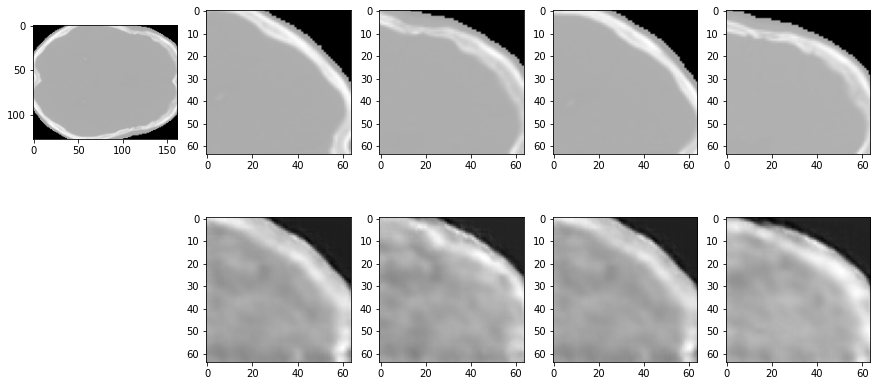

In [28]:
pred_4(directories[2],'CT')

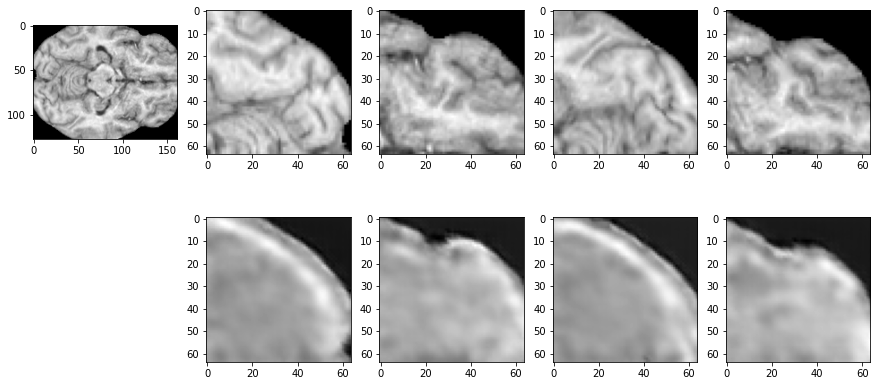

In [29]:
pred_4(directories[2],'MRI')

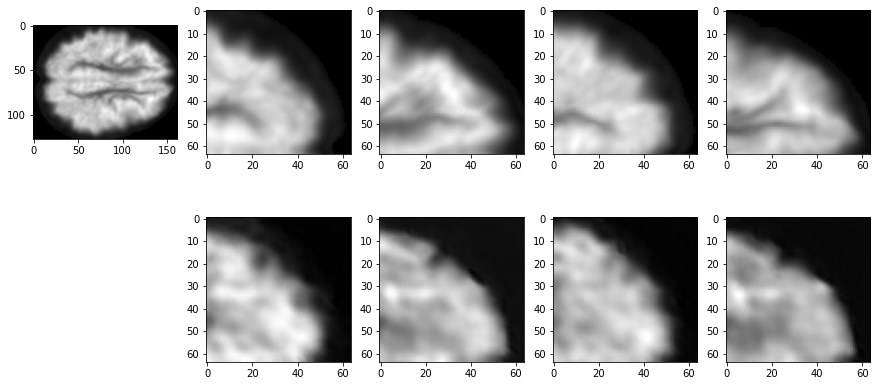

In [30]:
pred_4(directories[2],'PET')

# DCEC Model

In [31]:
autoencoder.load_weights(save_dir+save_as)

### Clustering Layer

In [32]:
from keras.engine.topology import Layer

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=3))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [33]:
from keras.engine.topology import InputSpec

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output[1])
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

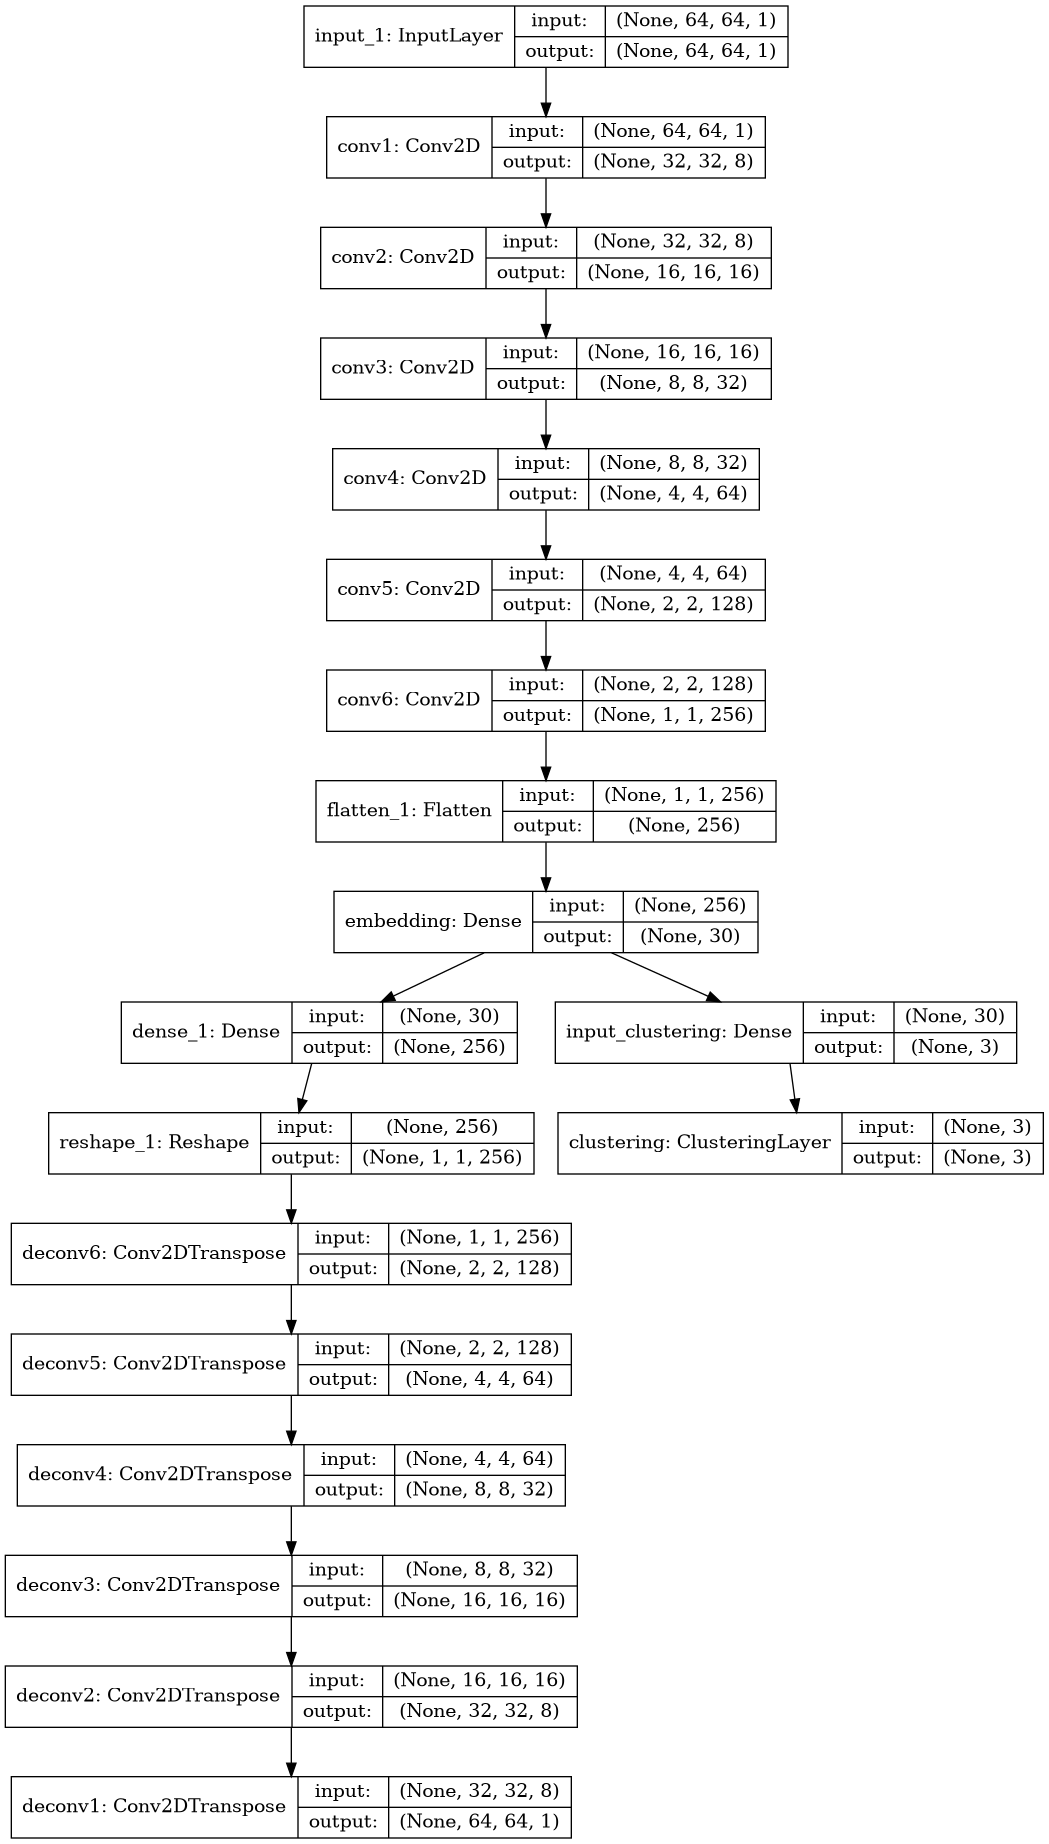

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Inizialize cluster centers using k-means

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

In [35]:
from sklearn.cluster import KMeans
import metrics as metrics

kmeans = KMeans(n_clusters=n_clusters, n_init=50)

y_pred = kmeans.fit_predict(encoder.predict(x_train)[1])
y_pred_last = np.copy(y_pred)

centers = kmeans.cluster_centers_
model.get_layer(name='clustering').set_weights([centers])

In [36]:
print('Metrics before training.')
print('acc=', metrics.acc(y_train, y_pred), 'nmi=', metrics.nmi(y_train, y_pred), 'ari=', metrics.ari(y_train, y_pred))

Metrics before training.
acc= 0.5004901960784314 nmi= 0.1555879898599236 ari= 0.09820131485268725


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


(2040, 3)


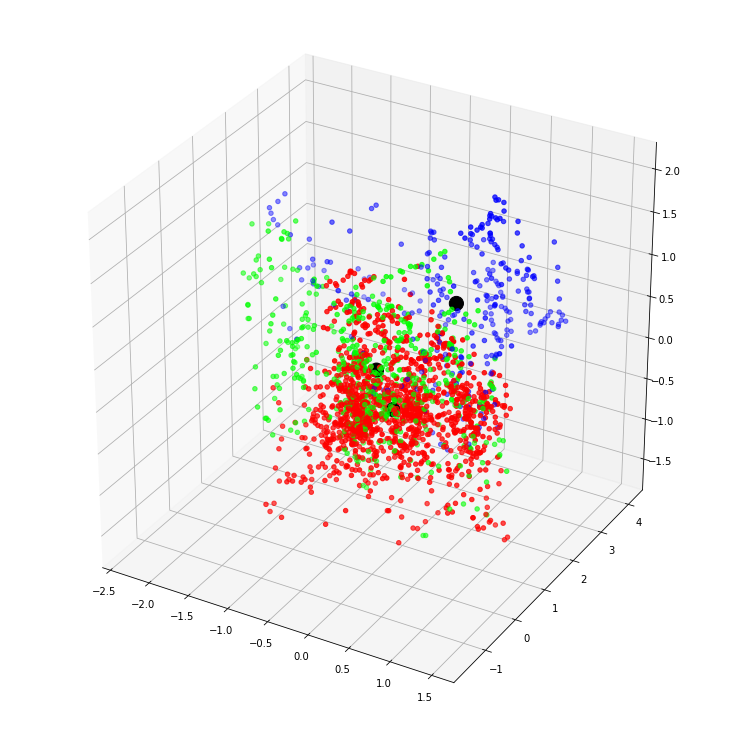

In [37]:
#%matplotlib notebook

from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure(figsize=(10,10))
ax = axes3d.Axes3D(fig)

features = encoder.predict(x_train)[1]
print(features.shape)

ax.scatter(features[:,0], features[:,1], features[:,2], c=y_pred, s=20, cmap='brg')
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='black', s=200, alpha=1)

# Training DCEC

In [38]:
# Student's distribution (see paper)
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [39]:
# hyperparams
batch_size= 64
maxiter = 100000
update_interval = 150
save_interval = 10000000000
tol = 0.01 # tolerance as threshold to early stopping

# init 
index = 0
train_loss=[]

# plots
history_train_losses = [[],[],[]]
history_train_acc=[]
iterazioni=[]

## Compile

In [40]:
# compile model
gamma = 0.1
optimizer = 'adam'

model.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)

## Train

In [41]:
import metrics

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x_train, verbose=0)
        p = target_distribution(q) # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_train_pred = q.argmax(1)
        if y_train is not None:
            train_acc = np.round(metrics.acc(y_train, y_train_pred), 5)
            train_nmi = np.round(metrics.nmi(y_train, y_train_pred), 5)
            train_ari = np.round(metrics.ari(y_train, y_train_pred), 5)
            train_loss = np.round(train_loss, 5)
            print('Iter', ite, ': Acc tr', train_acc, ', nmi tr', train_nmi, ', ari tr', train_ari, '; loss tr=', train_loss)
       
        # check stop criterion
        delta_label = np.sum(y_train_pred != y_pred_last).astype(np.float32) / y_train_pred.shape[0]
        y_pred_last = np.copy(y_train_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    # train on batch
    if (index + 1) * batch_size > x_train.shape[0]:
        train_loss = model.train_on_batch(x=x_train[index * batch_size::],
                                     y=[p[index * batch_size::], x_train[index * batch_size::]])
        index = 0
    else:
        train_loss = model.train_on_batch(x=x_train[index * batch_size:(index + 1) * batch_size],
                                     y=[p[index * batch_size:(index + 1) * batch_size],
                                        x_train[index * batch_size:(index + 1) * batch_size]])
        index += 1
    
    history_train_losses[0].append(train_loss[0])
    history_train_losses[1].append(train_loss[1])
    history_train_losses[2].append(train_loss[2])
    history_train_acc.append(train_acc)

    iterazioni.append(ite)
    
    if ite % save_interval == 0:
        # save DCEC model checkpoints
        print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
        model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')
        
    ite += 1

# save the trained model
print('saving model to:', save_dir + '/dcec_model_final.h5')
model.save_weights(save_dir + '/dcec_model_final.h5')

/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 0 : Acc tr 0.50049 , nmi tr 0.15559 , ari tr 0.0982 ; loss tr= []
saving model to: ./results/dcec_model_0.h5


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 150 : Acc tr 0.49804 , nmi tr 0.1502 , ari tr 0.09707 ; loss tr= [0.00338 0.02356 0.00103]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 300 : Acc tr 0.51569 , nmi tr 0.15427 , ari tr 0.10186 ; loss tr= [0.00587 0.04845 0.00103]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 450 : Acc tr 0.51765 , nmi tr 0.15641 , ari tr 0.10404 ; loss tr= [0.0082  0.06954 0.00125]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 600 : Acc tr 0.52402 , nmi tr 0.15767 , ari tr 0.10661 ; loss tr= [0.0091  0.07782 0.00132]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 750 : Acc tr 0.52647 , nmi tr 0.15877 , ari tr 0.10764 ; loss tr= [0.00832 0.07184 0.00114]
Iter 900 : Acc tr 0.52549 , nmi tr 0.15963 , ari tr 0.10802 ; loss tr= [0.00859 0.07387 0.00121]
delta_label  0.007352941176470588 < tol  0.01
Reached tolerance threshold. Stopping training.
saving model to: ./results/dcec_model_final.h5


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


## Plot DCEC metrics

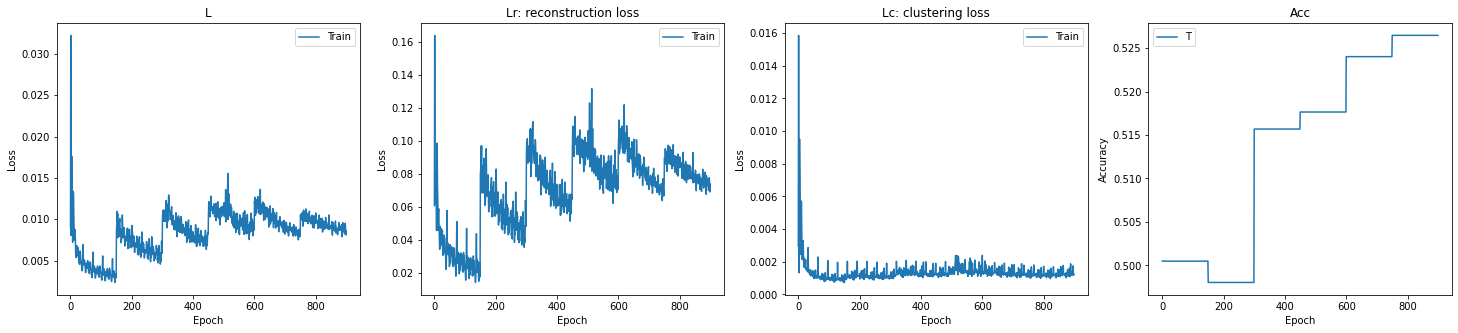

In [42]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
x1=iterazioni
y1=history_train_losses[0]
plt.plot(x1,y1)
plt.title('L')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,2)
x1=iterazioni
y1=history_train_losses[1]
plt.plot(x1,y1)
plt.title('Lr: reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,3)
x1=iterazioni
y1=history_train_losses[2]
plt.plot(x1,y1)
plt.title('Lc: clustering loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,4)
x1=iterazioni
y1=history_train_acc
plt.plot(x1,y1)
plt.title('Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train')

plt.show()

## Validation

In [43]:
## validation step

## Prediction after training 

In [ ]:
## fix prediction for model after train

In [44]:
model.load_weights(save_dir + '/dcec_model_final.h5')

AttributeError: 'list' object has no attribute 'reshape'

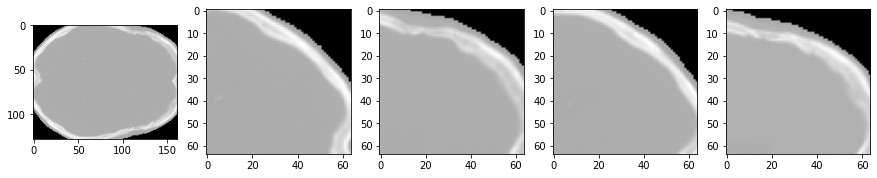

In [45]:
model = model

def pred_4(d,s):
    img = crop(GetImage(GetListPerType(d,s),d,n))
    img_1, img_3, img_4, img_6 = split_in_six(img)
    img_1 = cv2.flip(img_1, 1)
    img_4 = cv2.flip(img_4, -1)
    img_6 = cv2.flip(img_6, 0)
    
    plt.figure(figsize=(15,7))
    plt.gray()
    
    ax = plt.subplot(2,5,1)
    plt.imshow(img)
    ax = plt.subplot(2,5,2)
    plt.imshow(img_1)
    ax = plt.subplot(2,5,3)
    plt.imshow(img_3)
    ax = plt.subplot(2,5,4)
    plt.imshow(img_4)
    ax = plt.subplot(2,5,5)
    plt.imshow(img_6)

    img_1 = img_1.reshape((1,) + img_1.shape + (1,))
    img_3 = img_3.reshape((1,) + img_3.shape + (1,))
    img_4 = img_4.reshape((1,) + img_4.shape + (1,))
    img_6 = img_6.reshape((1,) + img_6.shape + (1,))

    img_1_p = model.predict(img_1)
    img_1_p = img_1_p.reshape((64,64))
    img_3_p = model.predict(img_3)
    img_3_p = img_3_p.reshape((64,64))
    img_4_p = model.predict(img_4)
    img_4_p = img_4_p.reshape((64,64))
    img_6_p = model.predict(img_6)
    img_6_p = img_6_p.reshape((64,64))
    
    ax = plt.subplot(2,5,7)
    plt.imshow(img_1_p)
    ax = plt.subplot(2,5,8)
    plt.imshow(img_3_p)
    ax = plt.subplot(2,5,9)
    plt.imshow(img_4_p)
    ax = plt.subplot(2,5,10)
    plt.imshow(img_6_p)

pred_4(directories[2],'CT')

# Final evaluation on test dataset

In [ ]:
q, _ = model.predict(x_test, verbose=0)
p = target_distribution(q) 
test_acc = []
test_loss = model.fit(x=x_test, y=[p, x_test])
print(' Test acc', test_acc) 

## Show prediction after training DCEC

### Prediction on test dataset

# Plotting clusters

### Train

In [ ]:
features = feature_model.predict(x_train)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

### Test

In [ ]:
features = feature_model.predict(x_test)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

## Confusion matrix

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y_test], y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind